# Sentiment Analysis Exercise

In this exercise We implement Sentiment analysis on Airline twitter tweets. The dataset consists of tweets users are doing to an airline. So the tweets can be positive, negative or neutral. 
We need to build a classifier and assess its accuracy on test data. We will use Logistic Regression to build this classifier.
We will need to check if the classes are imbalanced. we will use scoring functions like AUC-ROC scre, F1 score and plotting confusion matrix. We will see how to use AUC scoring for multiclass problems.  
We will build another classifier for positive /negative sentiment only and assess the its accuracy.  
We will also try interpreting the model by using weights.


In [1]:
import pandas as pd
import numpy as np
import re

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report

#For data visualisation
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df_ = pd.read_csv('AirlineTweets.csv')
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
df = df_[['airline_sentiment','text']]

In [4]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [5]:
df.shape

(14640, 2)

In [6]:
df.isnull().sum()

airline_sentiment    0
text                 0
dtype: int64

### Preprocessing and cleaning of text data

In [7]:
def remove_tag_words(text):
    result = re.sub('\@\w+','',text)
    return result

def remove_html_in_text(text):
    result_wo_chars = re.sub(r'https?://\S+|www\.\S+','', text)
    result = re.sub('\&\w+','',result_wo_chars)
    return result

def remove_numbers(text):
    result = re.sub(r'\d+','',text)
    return result

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(lemmas)

def remove_stop_words(text):
    stop_words = stopwords.words('english')
    tokens = word_tokenize(text)
    words = [t for t in tokens if t not in stop_words]
    return " ".join(words)

def remove_punctuation(text):
    punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    for punc in punctuation:
        text.replace(punc,'')
    return text

def extract_only_letters(text):
    text = re.sub('[^a-zA-Z]+', ' ', text).strip()
    return text

In [8]:
df['text'] = df['text'].apply(lambda x: remove_tag_words(x))
df['text'] = df['text'].apply(lambda x: remove_html_in_text(x))
df['text'] = df['text'].apply(lambda x: remove_numbers(x))
df['text'] = df['text'].apply(lambda x: remove_punctuation(x))
df['text'] = df['text'].apply(lambda x: extract_only_letters(x))
df['text'] = df['text'].apply(lambda x: lemmatize(x))
df['text'] = df['text'].apply(lambda x: remove_stop_words(x))

C:\Users\varakhedi\AppData\Local\Temp\ipykernel_29628\2042120263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(lambda x: remove_tag_words(x))
C:\Users\varakhedi\AppData\Local\Temp\ipykernel_29628\2042120263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(lambda x: remove_html_in_text(x))
C:\Users\varakhedi\AppData\Local\Temp\ipykernel_29628\2042120263.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

#### Checking class imbalance

<AxesSubplot:>

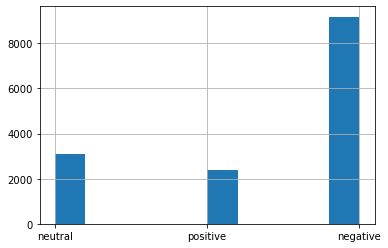

In [9]:
df['airline_sentiment'].hist()

The classes are imbalanced towards negative sentiments.

In [10]:
target_map={'negative':0, 'positive': 1, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)

C:\Users\varakhedi\AppData\Local\Temp\ipykernel_29628\1205227409.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df['airline_sentiment'].map(target_map)


In [11]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 0)
print(df_train.shape)
print(df_test.shape)

(11712, 3)
(2928, 3)


In [12]:
vectorizer = TfidfVectorizer(max_features = 2000)
X_train = vectorizer.fit_transform(df_train['text'])
X_train

<11712x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 91171 stored elements in Compressed Sparse Row format>

In [13]:
X_test = vectorizer.transform(df_test['text'])
X_test

<2928x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 22632 stored elements in Compressed Sparse Row format>

In [14]:
y_train = df_train['target']
y_test = df_test['target']

In [15]:
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [16]:
y_pred = model.predict(X_test)

#### Lets check the performance of the model

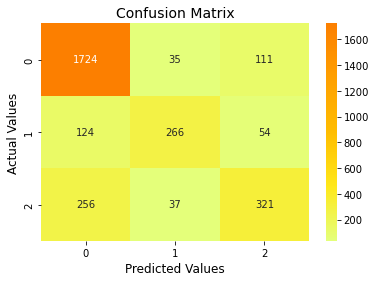

In [17]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = 'Wistia', fmt = '.8g')
plt.xlabel('Predicted Values',fontsize = 12)
plt.ylabel('Actual Values', fontsize = 12)
plt.title('Confusion Matrix', fontsize = 14)
plt.show()

In [18]:
print("Classification report - \n\n", classification_report(y_test,y_pred))

Classification report - 

               precision    recall  f1-score   support

           0       0.82      0.92      0.87      1870
           1       0.79      0.60      0.68       444
           2       0.66      0.52      0.58       614

    accuracy                           0.79      2928
   macro avg       0.76      0.68      0.71      2928
weighted avg       0.78      0.79      0.78      2928



In [19]:
y_proba = model.predict_proba(X_test)
roc_auc_score(y_test, y_proba, multi_class = 'ovo')

## Binary labels and model interpretation

In [22]:
binary_target_list = [target_map['positive'],target_map['negative']]
df_binary_train = df_train[df_train['target'].isin(binary_target_list)]
df_binary_test = df_test[df_test['target'].isin(binary_target_list)]

In [23]:
X_b_train = vectorizer.fit_transform(df_binary_train['text'])
X_b_test = vectorizer.transform(df_binary_test['text'])

In [24]:
y_b_train = df_binary_train['target']
y_b_test = df_binary_test['target']

In [25]:
model = LogisticRegression(max_iter = 500)
model.fit(X_b_train, y_b_train)
y_b_pred = model.predict(X_b_test)

#### Model performance for Binary classification

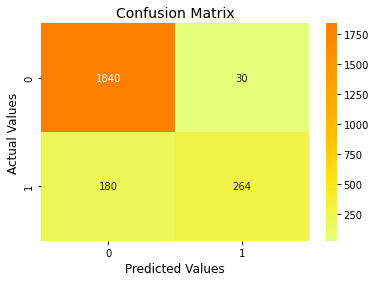

In [26]:
cm_b = confusion_matrix(y_b_test,y_b_pred)
sns.heatmap(cm_b, annot = True, cmap = 'Wistia', fmt = '.8g')
plt.xlabel('Predicted Values',fontsize = 12)
plt.ylabel('Actual Values', fontsize = 12)
plt.title('Confusion Matrix', fontsize = 14)
plt.show()

In [27]:
print("Classification report - \n\n", classification_report(y_b_test,y_b_pred))

Classification report - 

               precision    recall  f1-score   support

           0       0.91      0.98      0.95      1870
           1       0.90      0.59      0.72       444

    accuracy                           0.91      2314
   macro avg       0.90      0.79      0.83      2314
weighted avg       0.91      0.91      0.90      2314



In [28]:
y_b_proba = model.predict_proba(X_b_test)
roc_auc_score(y_b_test, y_b_proba[:,1] )

0.9468727417256829

We can see the model performs well on Binary data

### Model Interpretation

In [29]:
model.coef_

array([[-0.76816521,  0.92613268,  0.50055774, ..., -0.04207246,
        -0.4628063 , -0.30212279]])

(array([  1.,   0.,   0.,   2.,   7.,   2.,  24.,  35., 116., 421., 780.,
        331., 168.,  67.,  21.,  12.,   1.,   2.,   3.,   1.,   2.,   1.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([-4.52600962, -4.10656689, -3.68712416, -3.26768143, -2.84823871,
        -2.42879598, -2.00935325, -1.58991052, -1.17046779, -0.75102506,
        -0.33158234,  0.08786039,  0.50730312,  0.92674585,  1.34618858,
         1.76563131,  2.18507403,  2.60451676,  3.02395949,  3.44340222,
         3.86284495,  4.28228767,  4.7017304 ,  5.12117313,  5.54061586,
         5.96005859,  6.37950132,  6.79894404,  7.21838677,  7.6378295 ,
         8.05727223]),
 <BarContainer object of 30 artists>)

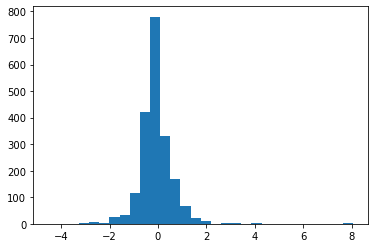

In [35]:
plt.hist(model.coef_[0], bins = 30)

Most of the weights are centred around and between -2 - 2. There are some outliers  beyond that too.

#### using the coeeficients to find most positive and most negative words

In [42]:
threshold = 2
word_index_map = vectorizer.vocabulary_
print("Most positive words ---- \n")
for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight > threshold:
        print(word, weight)

Most positive words ---- 

awesome 4.190676615924713
great 5.241346073904861
thank 8.05727222883735
appreciate 2.8434452769765253
love 4.451417429595945
good 3.045842002178882
thanks 7.664095334564186
excellent 2.8443788331340647
best 4.279021037827864
amazing 3.778205175463241
kudos 3.0632233558872977
thx 3.1697834024929166
worry 2.060734294540859
cool 2.142288996346278
excited 2.1901586056597817
wonderful 2.113989583118338


In [43]:
print("Most negative words ---- \n")
for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight < -threshold:
        print(word, weight)

Most negative words ---- 

bag -2.5762742223888884
hour -4.526009618143905
cancelled -2.671307424666809
delay -2.3528502786929057
call -2.4440055408820993
hold -2.866638183517669
worst -3.1011139251107362
delayed -2.635252716742937
rude -2.219761703065411
luggage -2.510609368227611
hr -2.5484584572310283
nothing -2.659809437971857
